In [1]:
import os
import json
from itertools import groupby
from torch.optim import Adam
from torch.nn import functional as nnf
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch
from torch import nn

import matplotlib.pyplot as plt

import clip
import numpy as np
from os.path import join, isdir, expanduser
from PIL import Image
from datetime import datetime
from time import time, sleep


data_path = expanduser('~/datasets')

exp_id = "07 mix"

In [2]:
trained_clip, _ = clip.load("ViT-B/32", device="cuda")

batch_size = 16

train_A = torch.load("A.pt")
train_B = torch.load("B.pt")

A_loader = torch.utils.data.DataLoader(train_A, batch_size=batch_size, shuffle=True, drop_last=True)
B_loader = torch.utils.data.DataLoader(train_B, batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        conv1 = nn.Conv2d(channels, channels, 3)
        bn1 = nn.BatchNorm2d(channels)
        relu = nn.ReLU()
        conv2 = nn.Conv2d(channels, channels, 3)
        bn2 = nn.BatchNorm2d(channels)
        
        self.Layers = nn.Sequential(conv1, bn1, relu, conv2, bn2)
        
    def forward(self, x):
        x_crop = x[:,:,2:-2,2:-2]
        return self.Layers(x) + x_crop
    

resblock = ResBlock(128).cuda()

dummydata = torch.randn([batch_size,128,84,84]).cuda()

print(resblock(dummydata).shape)
del resblock
del dummydata

torch.Size([16, 128, 80, 80])


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.padder =  nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding="same")
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        
        self.resblocks = nn.Sequential(*[ResBlock(128) for _ in range(5)])
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size= 2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size= 2, stride=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size= 9, stride=1, padding="same")
    
    def forward(self, x):
        for layer in [self.padder, self.conv1, self.conv2, self.conv3]:
            x = layer(x)
            
        x =  self.resblocks(x)
        
        x = nn.Tanh()(self.conv4(self.upconv2(self.upconv1(x))))
        
        return x
    
gen = Generator()
dummydata = torch.randn([batch_size,3,128,128])
print(gen(dummydata).shape)


del gen
del dummydata

torch.Size([16, 3, 128, 128])


In [8]:
class Discriminator_clip(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.resizer = transforms.Resize(224, interpolation=Image.BICUBIC)
        
        clip_trained, _ = clip.load("ViT-B/32", device="cuda")
        self.encoder = clip_trained.encode_image
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512,1)
        self.sig = nn.Sigmoid()
        
        
        

    def forward(self, x):
        
        x = self.resizer(x)
        
        x = self.flatten(self.encoder(x)).float()
        x = self.sig(self.linear(x))

        return x

        
dis = Discriminator_clip().cuda()
dummydata = torch.randn([batch_size,3,128,128]).cuda()
print(dis(dummydata).shape)


del dis
del dummydata

torch.Size([16, 1])


In [10]:
class Discriminator_normal(nn.Module):
    
    def __init__(self, d=64):
        super().__init__()
        
        self.lrelu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
       
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(d * 8,1)
        self.sig = nn.Sigmoid()
        
        
        

    def forward(self, x):
        
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.conv2_bn(self.conv2(x)))
        x = self.lrelu(self.conv3_bn(self.conv3(x)))
        x = self.lrelu(self.conv4_bn(self.conv4(x)))
        
        x = self.sig((self.linear(self.flatten(self.pool(x)))))

        return x

        
dis = Discriminator_normal().cuda()
dummydata = torch.randn([batch_size,3,128,128]).cuda()
print(dis(dummydata).shape)


del dis
del dummydata

torch.Size([16, 1])


In [11]:
class Discriminator_mix(nn.Module):
    
    def __init__(self, d=64):
        super().__init__()
        
        self.clip_disc = Discriminator_clip()
        self.disc_norm = Discriminator_normal(d=d)
        
    def forward(self, x, clip_frac = 0.5):
        x_clip = self.clip_disc(x)
        x_norm = self.disc_norm(x)
        return clip_frac * x_clip + (1 - clip_frac) * x_norm
    
dis = Discriminator_mix().cuda()
dummydata = torch.randn([batch_size,3,128,128]).cuda()
print(dis(dummydata).shape)


del dis
del dummydata

/home/epool08/.conda/envs/jonas_florian/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([16, 1])


In [12]:
from torchvision.transforms import Resize, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, Compose, InterpolationMode

transform_pipeline = Compose([
    RandomCrop(200),
    RandomHorizontalFlip(p=0.5),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    Resize(128, InterpolationMode.BICUBIC)
])

def unprocess(img):
    img = img.permute(1,2,0)
    img = img - img.min()
    return img / img.max()

def show(images):
    l = len(images)
   
    _, axs = plt.subplots(1, l, figsize=(15,7))
    for i, img in enumerate(images):
        axs[i].imshow(unprocess(img))
        axs[i].axis('off')
    plt.show()

test = next(iter(A_loader))
    
res = transform_pipeline(test)

In [14]:
G_ab = Generator().cuda()
G_ba = Generator().cuda()

D_a = Discriminator_mix(64).cuda()
D_b = Discriminator_mix(64).cuda()

opt_G = Adam(list(G_ab.parameters()) + list(G_ba.parameters()), lr=0.0002, betas=(0.5, 0.999))
opt_D_a = Adam(D_a.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_D_b = Adam(D_b.parameters(), lr=0.0001, betas=(0.5, 0.999))
losses = [[], [], []]

In [15]:
def saver(G_ab, G_ba, D_a, D_b, exp_id = ""):
    now = datetime.now()
    time = now.strftime("%m.%d._%H:%M")
    
    path = os.path.join("saves", exp_id, time)
    
    os.makedirs(path)
    
    names = ["G_ab", "G_ba", "D_a", "D_b"]
    models = [G_ab, G_ba, D_a, D_b]
    
    for name, model in zip(names, models):
        torch.save(model.state_dict(), os.path.join(path, name + ".pt"))
        


In [17]:
epochs = 999

last_save = time()

for i in range(epochs):
    
    clip_frac = i / (epochs + 1)
    
    if time() - last_save >= 1800:
        last_save = last_save + 1800
        saver(G_ab, G_ba, D_a, D_b, exp_id)
    
    for a_batch, b_batch in zip(A_loader, B_loader):

        a_batch = transform_pipeline(a_batch).cuda().float()
        b_batch = transform_pipeline(b_batch).cuda().float()

        ones, zeros = torch.ones(batch_size,1).cuda(), torch.zeros(batch_size,1).cuda()
        # train generators

        opt_G.zero_grad()

        G_ab.train()
        G_ba.train()

        # if input is from right distribution (or class) already: don't change it
        loss_eye = (nnf.l1_loss(G_ba(a_batch), a_batch) + nnf.l1_loss(G_ab(b_batch), b_batch)) / 2

        # let's fool the discriminator a bit...
        fake_a, fake_b = G_ba(b_batch), G_ab(a_batch)
        loss_fool_d = (nnf.mse_loss(D_a(fake_a, clip_frac=clip_frac), ones) + nnf.mse_loss(D_b(fake_b, clip_frac=clip_frac), ones)) / 2

        # by applying the generators twice we should be back at the initial sample
        loss_cycle = (nnf.l1_loss(G_ba(fake_b), a_batch) + nnf.l1_loss(G_ab(fake_a), b_batch)) / 2

        loss_g = 5 * loss_eye  + loss_cycle * 10 + loss_fool_d
        loss_g.backward()
        opt_G.step()

        # train discriminator A
        opt_D_a.zero_grad()
        loss_d_a = 0.5 * nnf.mse_loss(D_a(a_batch, clip_frac=clip_frac), ones)
        loss_d_a += 0.5 * nnf.mse_loss(D_a(fake_a.detach(), clip_frac=clip_frac), zeros)
        loss_d_a.backward()
        opt_D_a.step()

        # train discriminator B
        opt_D_b.zero_grad()
        loss_d_b = 0.5 * nnf.mse_loss(D_b(b_batch, clip_frac=clip_frac), ones)
        loss_d_b += 0.5 * nnf.mse_loss(D_b(fake_b.detach(), clip_frac=clip_frac), zeros)
        loss_d_b.backward()
        opt_D_b.step()

        losses[0] += [float(loss_g)]
        losses[1] += [float(loss_d_a)]
        losses[2] += [float(loss_d_b)]
        
        del a_batch
        del b_batch
        torch.cuda.empty_cache()        
        

    print(f'generator: {np.mean(losses[0]):.5f}, D_a: {np.mean(losses[1]):.5f}, D_b: {np.mean(losses[2]):.5f}')


generator: 22.21807, D_a: 0.22840, D_b: 0.22643
generator: 21.11067, D_a: 0.20561, D_b: 0.19834


KeyboardInterrupt: 

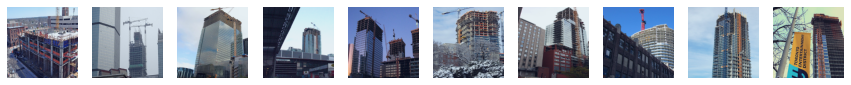

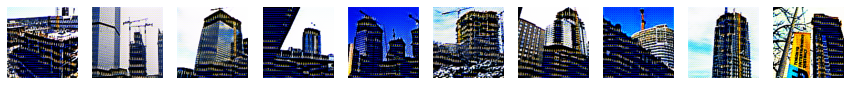

In [10]:
test_a = next(iter(A_loader))
test_a = transform_pipeline(test_a)

show(test_a[:10])

res = G_ab(test_a[:10].cuda()).cpu().detach()
show(res)

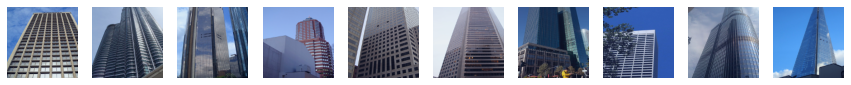

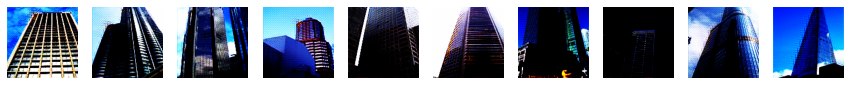

In [11]:
test_b = next(iter(B_loader))
test_b = transform_pipeline(test_b)

show(test_b[:10])

res = G_ba(test_b[:10].cuda()).cpu().detach()
show(res)